In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag
from pymatching import Matching


def repetition_code(n):
    """
    Parity check matrix of a repetition code with length n.
    """
    row_ind, col_ind = zip(*((i, j) for i in range(n) for j in (i, (i+1)%n)))
    data = np.ones(2*n, dtype=np.uint8)
    return csc_matrix((data, (row_ind, col_ind)))


def toric_code_x_stabilisers(L):
    """
    Sparse check matrix for the X stabilisers of a toric code with
    lattice size L, constructed as the hypergraph product of
    two repetition codes.
    """
    Hr = repetition_code(L)
    H = hstack(
            [kron(Hr, eye(Hr.shape[1])), kron(eye(Hr.shape[0]), Hr.T)],
            dtype=np.uint8
        )
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)

In [2]:
def toric_code_x_logicals(L):
    """
    Sparse binary matrix with each row corresponding to an X logical operator
    of a toric code with lattice size L. Constructed from the
    homology groups of the repetition codes using the Kunneth
    theorem.
    """
    H1 = csc_matrix(([1], ([0],[0])), shape=(1,L), dtype=np.uint8)
    H0 = csc_matrix(np.ones((1, L), dtype=np.uint8))
    x_logicals = block_diag([kron(H1, H0), kron(H0, H1)])
    x_logicals.data = x_logicals.data % 2
    x_logicals.eliminate_zeros()
    return csc_matrix(x_logicals)

In [6]:
H = toric_code_x_stabilisers(5)
H_log = toric_code_x_logicals(5)
matching=Matching(H)

In [20]:
noise = np.random.binomial(1, 0.03, H.shape[1])
noise

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [21]:
syndrome = H@noise % 2
syndrome

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [22]:
prediction = matching.decode(syndrome)
prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8)

In [24]:
predicted_logicals_flipped = H_log@prediction % 2
predicted_logicals_flipped

array([0, 0], dtype=uint8)

In [26]:
actual_logicals_flipped = H_log@noise % 2
actual_logicals_flipped

array([0, 0])

In [27]:
def num_decoding_failures_via_physical_frame_changes(H, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-error_probability)/error_probability))
    num_errors = 0
    for i in range(num_shots):
        noise = (np.random.random(H.shape[1]) < error_probability).astype(np.uint8)
        syndrome = H@noise % 2
        prediction = matching.decode(syndrome)
        predicted_logicals_flipped = logicals@prediction % 2
        actual_logicals_flipped = logicals@noise % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors

In [28]:
def num_decoding_failures(H, logicals, p, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-p)/p), faults_matrix=logicals)
    num_errors = 0
    for i in range(num_shots):
        noise = (np.random.random(H.shape[1]) < p).astype(np.uint8)
        syndrome = H@noise % 2
        predicted_logicals_flipped = matching.decode(syndrome)
        actual_logicals_flipped = logicals@noise % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors

In [29]:
def num_decoding_failures_vectorised(H, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-p)/p), faults_matrix=logicals)
    noise = (np.random.random((num_shots, H.shape[1])) < error_probability).astype(np.uint8)
    shots = (noise @ H.T) % 2
    actual_observables = (noise @ logicals.T) % 2
    predicted_observables = matching.decode_batch(shots)
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors

In [30]:
%%time

num_shots = 5000
Ls = range(4,14,4)
ps = np.linspace(0.01, 0.2, 9)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, p, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...
CPU times: user 1.32 s, sys: 8.7 ms, total: 1.33 s
Wall time: 1.33 s


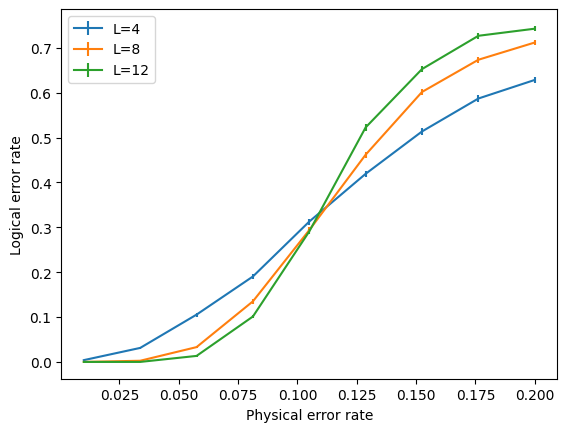

In [31]:
%matplotlib inline

plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

### Noisy Syndromes

In [32]:
def num_decoding_failures_noisy_syndromes(H, logicals, p, q, num_shots, repetitions):
    matching = Matching(H, weights=np.log((1-p)/p),
                repetitions=repetitions, timelike_weights=np.log((1-q)/q), faults_matrix=logicals)
    num_stabilisers, num_qubits = H.shape
    num_errors = 0
    for i in range(num_shots):
        noise_new = (np.random.rand(num_qubits, repetitions) < p).astype(np.uint8)
        noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
        noise_total = noise_cumulative[:,-1]
        syndrome = H@noise_cumulative % 2
        syndrome_error = (np.random.rand(num_stabilisers, repetitions) < q).astype(np.uint8)
        syndrome_error[:,-1] = 0 # Perfect measurements in last round to ensure even parity
        noisy_syndrome = (syndrome + syndrome_error) % 2
        # Convert to difference syndrome
        noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2
        predicted_logicals_flipped = matching.decode(noisy_syndrome)
        actual_logicals_flipped = noise_total@logicals.T % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors

In [33]:
%%time

num_shots = 3000
Ls = range(8,13,2)
ps = np.linspace(0.02, 0.04, 7)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures_noisy_syndromes(Hx, logX, p, p, num_shots, L)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=8...
Simulating L=10...
Simulating L=12...
CPU times: user 13.7 s, sys: 0 ns, total: 13.7 s
Wall time: 13.7 s


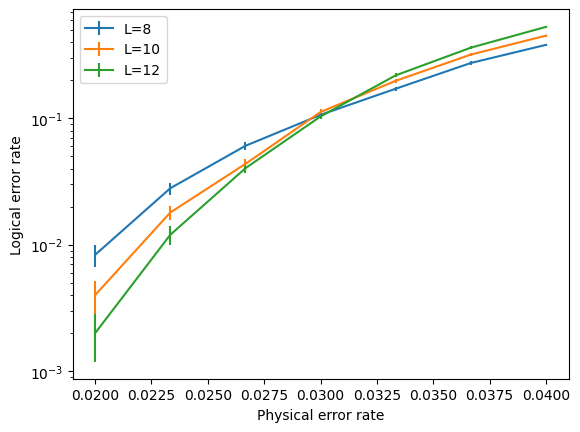

In [35]:
%matplotlib inline

plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

### Simulating Circuit-Level Noise

In [41]:
%%time

import stim

num_shots = 20000
Ls = range(2,5,1)
ps = np.linspace(0.004, 0.01, 7)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    log_errors = []
    for p in ps:
        circuit = stim.Circuit.generated("surface_code:rotated_memory_x",
                                        distance=L,
                                        rounds=L,
                                        after_clifford_depolarization=p,
                                        before_round_data_depolarization=p,
                                        after_reset_flip_probability=p,
                                        before_measure_flip_probability=p)
        model = circuit.detector_error_model(decompose_errors=True)

        matching = Matching.from_detector_error_model(model)
        sampler = circuit.compile_detector_sampler()
        syndrome, actual_observables = sampler.sample(shots=num_shots, separate_observables=True)
        predicted_observables = matching.decode_batch(syndrome)
        num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=2...
Simulating L=3...
Simulating L=4...
CPU times: user 380 ms, sys: 157 µs, total: 380 ms
Wall time: 380 ms


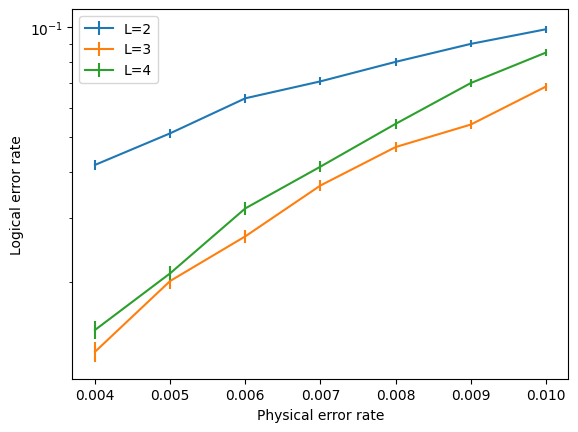

In [42]:
%matplotlib inline

plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);